# Calculation of moving time

In this section, we focus on the following **three issues**.  

1.How often are the wagons moved?  
2.Which differences can be identified between the wagon types?  
3.Are there seasonal dependencies?

In [5]:
import gc
import pandas as pd
import numpy as np
from time_moving import time_moving
import data_loader_sortvalue
import glob
import matplotlib.pyplot as plt

In [ ]:
dtype = {'wagon_ID': str,
          'timestamp_measure_position': str,
          'movement_state': str}

use_cols = ['wagon_ID',
            'movement_state',
            'timestamp_measure_position']

In [ ]:
# read 45 pre-processed files
for i in range(1,46):

    print('{:02}/45 Reading file'.format(i))
    data = data_loader_sortvalue.load_raw_csv(i)
    print('Loading finished')

    # Crate a new dataframe and some lists to store the data.
    groups = data.groupby("wagon_ID", as_index=False)
    Time_set = pd.DataFrame(columns=['wagon_ID', 'Time_moving{:02}'.format(i), 'Time_total{:02}'.format(i),
                                     'Time_start{:02}'.format(i)])
    Time_wagon_ID = []
    Time_moving = []
    Time_total = []
    Time_start = []

    # import function 'time_moving' to calculate time.
    for name, group in groups:
        Time = time_moving(group)
        Time_wagon_ID.append(name)
        Time_moving.append(Time[0])
        Time_total.append(Time[1])
        Time_start.append(Time[2])

    # Creating a dataframe with above lists
    Time_set = pd.DataFrame({'wagon_ID': Time_wagon_ID, 'Time_moving{:02}'.format(i): Time_moving,
                             'Time_total{:02}'.format(i): Time_total, 'Time_start{:02}'.format(i): Time_start})
    
    # To save memory space, re-write the time data in each long-term file as a new file
    print('Saving')
    Time_set.to_csv('../../../data/writedown/writedown{:02}.csv'.format(i), index=False)
    print('Saved')
    print(data.info(verbose=False, memory_usage="deep"))

del data
gc.collect()

Merge all new files with the provided file containing all wagon IDs

In [ ]:
# Set the address of the source file with ID information
path = '../../../data/211202_wagon_type_mapping.csv'

# Set the address of the file to be read
input_path = glob.glob('../../../data/writedown/writedown*.csv')

with open(path, 'r') as f:
     result = pd.read_csv(f)
# Loop from the address of the file to be read
for file in input_path:
    with open(file, 'r') as v:
         right = pd.read_csv(v)
         # Use the merge function to merge the two files together
         # Use the source file as the base, and 'wagon_ID' as the merge key to merge with each writedown-file
         result = pd.merge(result, right, how = 'left', on = 'wagon_ID')
    # Overwrite the source file with the newly stitched file and loop the overlay
    # All missing values in the file are set to 0
    result.to_csv('../../../data/211202_wagon_type_mapping_new.csv', na_rep='0', index=None)

Calculate the relevant time from the merged file, and draw the corresponding box and line plots：    
1.The ratio of moving time for different types of trains in 4 quarters  
2.The ratio of moving time for different types of trains in 12 months  
3.The ratio of moving time for each type by Boxplots in four quarters   
4.The ratio of moving time for each type by Boxplots 

In [10]:
# define a function, which is used to calculate the ratio.
def ratio(week_start, week_end, df):
    # The list of columns('Time_moving**')
    List_moving = np.arange(4 + 3 * week_start, 4 + 3 * week_end, 3)
    # The list of columns('Time_total**')
    List_total = np.arange(5 + 3 * week_start, 4 + 3 * week_end, 3)
    # The list of columns('Time_start**')
    List_start = np.arange(6 + 3 * week_start, 4 + 3 * week_end, 3)
    total_sum = df.iloc[:, List_total].sum(axis=1)
    moving_sum = df.iloc[:, List_moving].sum(axis=1)
    # the quotient of both 'sum' is ratio
    return moving_sum / total_sum


dtype = {'provider': np.uint8,
         'wagon_type': np.uint8,
         'wagon_construction': np.uint16}

# read csv data
wagon_info = pd.read_csv('/Users/dong/PycharmProjects/211202_wagon_type_mapping.csv', dtype=dtype)

# change data type
for i in range(1, 46):
    wagon_info['Time_start{:02}'.format(i)] = pd.to_timedelta(wagon_info['Time_start{:02}'.format(i)])
    wagon_info['Time_total{:02}'.format(i)] = pd.to_timedelta(wagon_info['Time_total{:02}'.format(i)])
    wagon_info['Time_moving{:02}'.format(i)] = pd.to_timedelta(wagon_info['Time_moving{:02}'.format(i)])

# Calculate the ratio of all weeks.
wagon_info['ratio'] = ratio(0, 45, wagon_info)

# define some lists to calculate different seasons, 12 weeks for the first three quarters, 9 weeks for the last one.
weeks_start = [0, 12, 24, 36]
weeks_end =[12, 24, 36, 45]
weeks_start_month = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44]
weeks_end_month = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 45]
seasons = ['1st', '2nd', '3rd', '4rd']
each_month = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

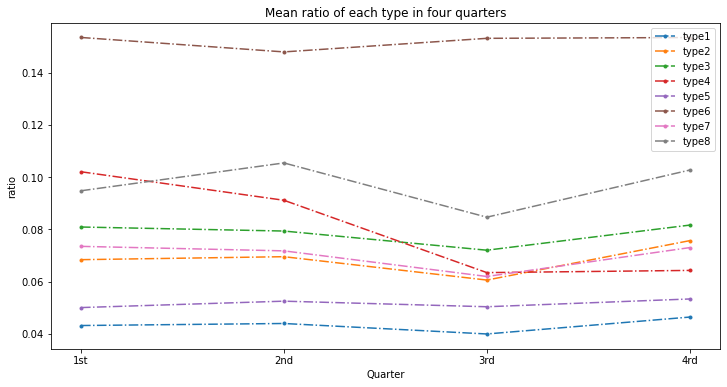

In [19]:
# This loop is used to calculate the ratio of the four quarters.
for week_start, week_end, season in zip(weeks_start, weeks_end, seasons):
    wagon_info[season] = ratio(week_start, week_end, wagon_info)

# This loop is used to create a dic. Key is type. Value is a list, that consists of the mean of the ratio in different
# quarters.
ratio_means = {}
for i in range(1, 9):
    aa = []
    for season in seasons:
        aa.append(wagon_info[wagon_info['wagon_type'] == i][season].mean())
    ratio_means[i] = aa

# figure1: Ratio of each type in four quarters
plt.figure(1, figsize=(12, 6))
for i in range(1, 9):
    plt.plot(seasons, ratio_means[i], '-..', label='type' + str(i))
plt.legend(loc='upper right')
plt.xlabel('Quarter')
plt.ylabel('ratio')
plt.title('Mean ratio of each type in four quarters')
plt.show()

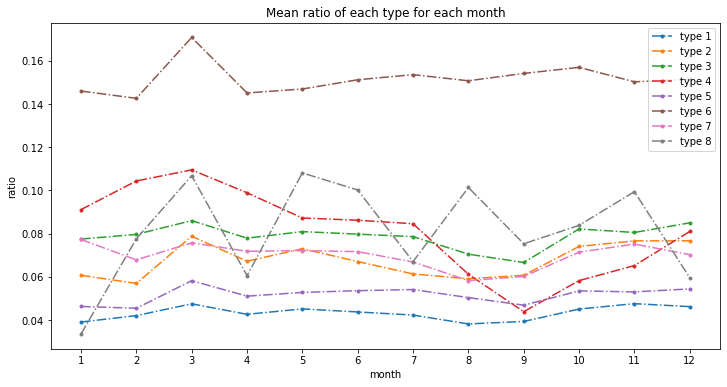

In [21]:
# This loop is used to calculate the ratio of each month.
for week_start, week_end, month in zip(weeks_start_month, weeks_end_month, each_month):
    wagon_info[month] = ratio(week_start, week_end, wagon_info)

# This loop is used to create a dic. Key is type. Value is a list, that consists of the mean of the ratio in different
# month.
ratio_means_month = {}
for i in range(1, 9):
    bb = []
    for month in each_month:
        bb.append(wagon_info[wagon_info['wagon_type'] == i][month].mean())
    ratio_means_month[i] = bb

# figure2: Ratio of each type in each month
plt.figure(2, figsize=(12, 6))
for i in range(1, 9):
    plt.plot(each_month, ratio_means_month[i], '-..', label='type ' + str(i))
plt.legend(loc='upper right')
plt.xlabel('month')
plt.ylabel('ratio')
plt.title('Mean ratio of each type for each month')
plt.show()

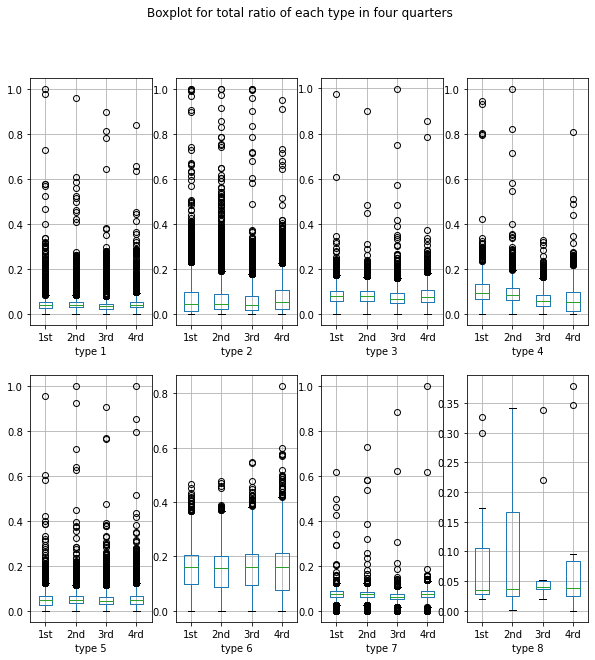

In [29]:
# figure3: Boxplots in four quarters for each type
plt.figure(3, figsize=(10, 10))
plt.suptitle('Boxplot for total ratio of each type in four quarters')
for i in range(1, 9):
    p = plt.subplot(2,4,i)
    plt.xlabel('type '+str(i))
    wagon_info[wagon_info['wagon_type'] == i].boxplot(column=['1st', '2nd', '3rd', '4rd'])
plt.show()

<Figure size 864x432 with 0 Axes>

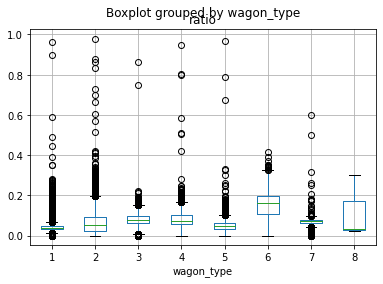

In [28]:
# figure4: The ratio of moving time for each type by Boxplots
plt.figure(4, figsize=(12, 6))
wagon_info.boxplot(column='ratio', by='wagon_type')

plt.show()

## Conclusion

1.Time ratio do not swing much from quarter to quarter for most wagon types，but they swing much from month to month   
2.Type 6 wagons have the largest time ratio and Type 1 wagons have the smallest time.   
3.Each type of wagon had a relatively small ratio of movement in the third quarter.